In [43]:
import re
import numpy as np 
import matplotlib.pyplot as plt 
import whisper
import os
import pandas as pd
import Ort

In [44]:
def to_string(path):
    with open(path, "r", encoding = "ISO-8859-1") as f:
        filtered_lines = []
        for line in f:
            if re.search(r'"[a-zA-Z0-9\.\s]*"', line):
                filtered_lines.append(line.strip())


        # Remove the first 6 lines
        filtered_lines = filtered_lines[6:]
        # Remove the last 4 lines
        # filtered_lines = filtered_lines[:4]

        all_text = ""

        # Print the filtered text
        for line in filtered_lines:
            # Skip string if empty
            if line == '""':
                continue

            # add a space after each line
            line += " "

            all_text += line

        # Remove all double quotes from the text
        all_text = all_text.replace('"', '')

        return all_text
    

In [45]:
def run_model(model_name):
    model = whisper.load_model(model_name)
    audiofile = os.getcwd() + "/fn000151.wav"
    return model.transcribe(audiofile, fp16=False)

In [46]:
from datasets import Audio, Dataset, load_dataset, load_metric

def evaluate(result, ort_transcription):
    target = [ort_transcription]
    prediction = [result['text']]
    prediction = [result['text']]

    # load metric
    wer = load_metric("wer")
    cer = load_metric("cer")

    # compute metrics
    wer_result = wer.compute(references=target, predictions=prediction)
    cer_result = cer.compute(references=target, predictions=prediction)

    return {'wer': wer_result, 'cer': cer_result}

In [47]:
def get_metadata(file_number):
    metadata = pd.DataFrame(pd.read_csv("recordings_NL.txt", sep='\t', header=0, names=['Root', 'SpeakerID', 'Component', 'Group', 'Age', 'Gender', 'CEF', 'DialectRegion', 'Duration (seconds)', 'Duration (days)']))
    suptitle = metadata.loc[metadata['Root'] == file_number]
    txt = "Group: {group}, Age: {age}, Gender: {gender}, CEF: {cef}, DialectRegion: {dialectregion}"
    txt = txt.format(group = suptitle['Group'].iloc[0], age = suptitle['Age'].iloc[0], gender=suptitle['Gender'].iloc[0], cef=suptitle['CEF'].iloc[0], dialectregion=suptitle['DialectRegion'].iloc[0])
    return txt

In [48]:
def visualise(ort_transcription): 
    data_tiny = evaluate(run_model("tiny"), ort_transcription)
    data_base = evaluate(run_model("base"), ort_transcription)
    data_small = evaluate(run_model("small"), ort_transcription)
    data_medium = evaluate(run_model("medium"), ort_transcription)
    data_large = evaluate(run_model("large"), ort_transcription)
  
    X = ['tiny', 'base', 'small', 'medium', 'large']
    Ywer = [data_tiny['wer'], data_base['wer'], data_small['wer'], data_medium['wer'], data_large['wer']]
    Zcer = [data_tiny['cer'], data_base['cer'], data_small['cer'], data_medium['cer'], data_large['cer']]
  
    X_axis = np.arange(len(X))
  
    plt.bar(X_axis - 0.2, Ywer, 0.4, label = 'wer')
    plt.bar(X_axis + 0.2, Zcer, 0.4, label = 'cer')
  
    plt.xticks(X_axis, X)
    plt.xlabel("Model")
    plt.ylabel("Error rate")
    plt.title(get_metadata('fn000151'), fontsize=10, style='italic')
    plt.suptitle("Whisper model comparison", fontsize=14, fontweight='bold')
    plt.legend()
    return plt.show()

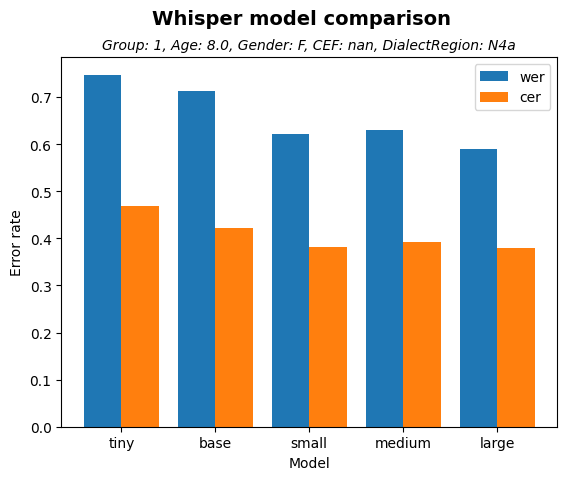

In [50]:
visualise(ort_transcription)